In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Load data split train, val

In [ ]:
from datasets import load_dataset

data_dir = "/content/drive/MyDrive/Colab Notebooks/imageprocessProjectInput"  # 將 MyDrive 替換為您的資料夾名稱

In [ ]:
# 載入訓練集和測試集
train_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "training_set"), split="train")
test_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "testing_set"), split="train")

# label2idx and idx2label
# 建立標籤和索引之間的映射
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}

# split train, val
# 將訓練集分割成訓練集和驗證集
splits = train_ds.train_test_split(test_size=0.1, shuffle=True, seed=42)
train_ds, val_ds = splits["train"], splits["test"]

# 顯示資料集資訊
print("Features", train_ds.features)
print("Train", train_ds)
print("Validation", val_ds)
print("Test", test_ds)
print("Num labels", len(label2id))
print("Label2Idx", label2id)

Resolving data files:   0%|          | 0/4001 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/1001 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Features {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Heart', 'Oblong', 'Oval', 'Round', 'Square'], id=None)}
Train Dataset({
    features: ['image', 'label'],
    num_rows: 3600
})
Validation Dataset({
    features: ['image', 'label'],
    num_rows: 400
})
Test Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})
Num labels 5
Label2Idx {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}


# Visualize some images and labels

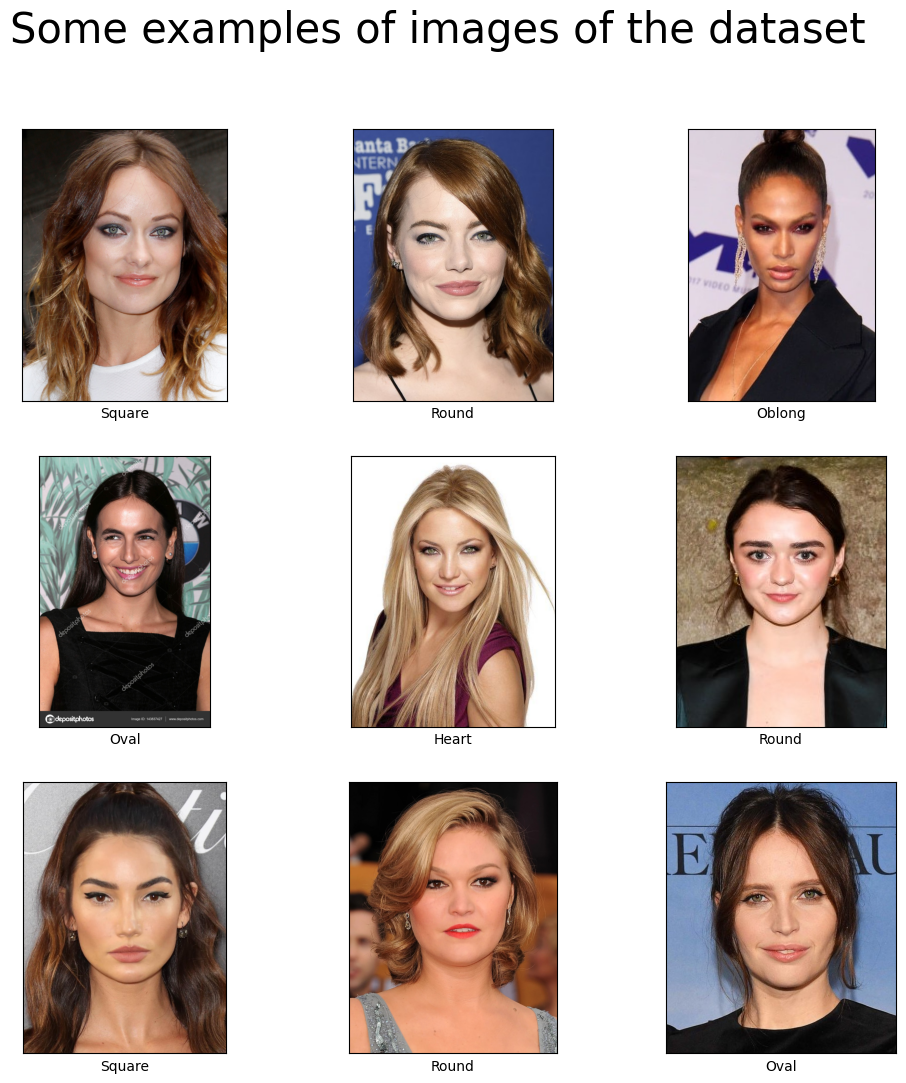

In [ ]:
import cv2
import matplotlib.pyplot as plt
from random import randint

# 定義顯示範例圖片的函式
list_idx = [randint(0, len(train_ds)) for i in range(9)]
def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Some examples of images of the dataset", fontsize=30)
    for i, idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_ds[idx]["image"], cmap=plt.cm.binary)
        plt.xlabel(id2label[train_ds[idx]["label"]])
    plt.show()

# 顯示範例圖片
display_examples()

# Transforms

In [ ]:
from transformers import AutoFeatureExtractor
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)

# 載入特徵提取器
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# 載入特徵提取器
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# 定義訓練集和驗證集的資料增強
_train_transforms = Compose(
    [
        RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),  # 從字典中訪問高度和寬度
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

_val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], feature_extractor.size['width'])), # Access height and width from the dictionary
            CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])), # Access height and width from the dictionary
            ToTensor(),
            normalize,
        ]
    )

# 定義應用資料增強的函式
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
# 對資料集應用資料增強
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# 顯示特徵提取器的均值和標準差
feature_extractor.image_mean, feature_extractor.image_std

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
# 顯示特徵提取器資訊
feature_extractor

ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

# Dataloader

In [ ]:
from torch.utils.data import DataLoader
import torch

# 定義資料整理函式
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# 建立訓練集資料載入器
train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

# Deffine the model

In [ ]:
from transformers import SwinForImageClassification, SwinConfig

# 定義模型配置
config = SwinConfig.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        finetuning_task="image-classification"
    )

# 載入預訓練模型
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    config=config,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

# 定義訓練參數
metric_name = "accuracy"
args = TrainingArguments(
    f"faceshape",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=21,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Load metric

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
from evaluate import load
import numpy as np

# 載入評估指標
metric = load(metric_name)

# 定義計算評估指標的函式
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# 建立訓練器
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

<ipython-input-15-f6eb762f37f6>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 禁用 Weights & Biases
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

# 處理可能出現的圖片載入錯誤
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 開始訓練模型
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.435288,0.342500
2,No log,1.232904,0.510000
3,No log,1.135982,0.560000
4,No log,1.046277,0.612500
5,1.277300,1.047763,0.567500
6,1.277300,0.942834,0.630000
7,1.277300,0.966280,0.637500
8,1.277300,0.905068,0.680000
9,0.888500,0.835907,0.710000
10,0.888500,0.824327,0.707500


TrainOutput(global_step=2260, training_loss=0.8203253416888482, metrics={'train_runtime': 3817.2663, 'train_samples_per_second': 18.862, 'train_steps_per_second': 0.592, 'total_flos': 1.789781226799104e+18, 'train_loss': 0.8203253416888482, 'epoch': 20.0})

# Validation

In [ ]:
# 評估模型在驗證集上的表現
trainer.evaluate()

{'eval_loss': 0.7477984428405762,
 'eval_accuracy': 0.735,
 'eval_runtime': 7.6507,
 'eval_samples_per_second': 52.283,
 'eval_steps_per_second': 1.699,
 'epoch': 20.0}

# Evaluation on test set

In [ ]:
# 評估模型在測試集上的表現
outputs = trainer.predict(test_ds)
print(outputs.metrics)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 取得真實標籤和預測標籤
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = train_ds.features['label'].names

{'test_loss': 0.7661802768707275, 'test_accuracy': 0.717, 'test_runtime': 480.7879, 'test_samples_per_second': 2.08, 'test_steps_per_second': 0.067}


# Classification report

In [ ]:
# Classification report
from sklearn.metrics import classification_report

# 顯示分類報告
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Heart       0.69      0.71      0.70       200
      Oblong       0.77      0.73      0.75       200
        Oval       0.58      0.61      0.60       200
       Round       0.72      0.78      0.75       200
      Square       0.85      0.74      0.79       200

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



# Confusion matrix

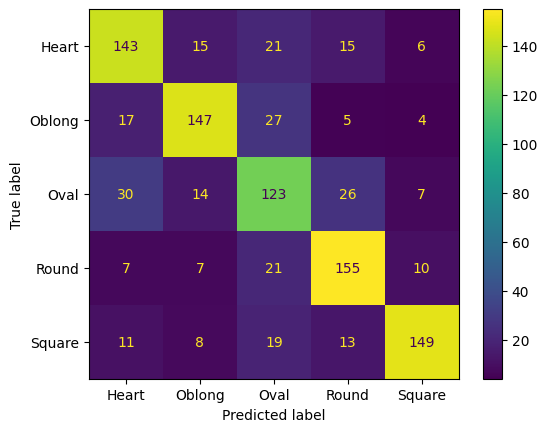

In [ ]:
# Confusion matrix
# 顯示混淆矩陣
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Visualize some predicted results

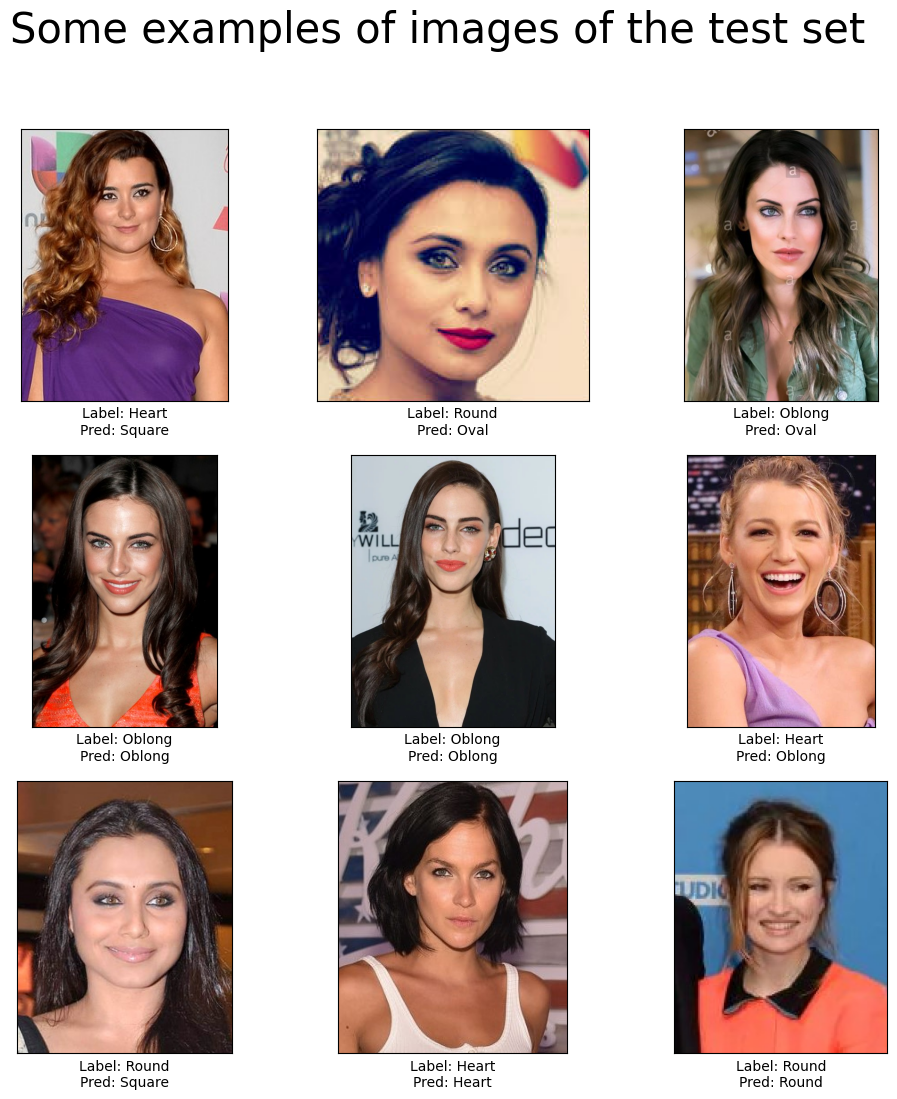

In [ ]:
import cv2
import matplotlib.pyplot as plt
from random import randint

# 定義顯示預測結果的函式
list_idx = [randint(0, len(test_ds)) for i in range(9)]

def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Some examples of images of the test set", fontsize=30)
    for i,idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_ds[idx]["image"], cmap=plt.cm.binary)
        plt.xlabel("Label: "+id2label[y_true[idx]]+"\nPred: "+id2label[y_pred[idx]])
    plt.show()

# 顯示預測結果
display_examples()